# Sliderule data I/O

This notebook will highlight analyzing various coincident elevation measurements. We will find regions with and use sliderule to retrieve ICESat-2 and GEDI point elevation measurements.

```{note}
Keep in mind, these measurements are from different sensor types, close in time, but not at exactly the same time. All measurements also have uncertainties, so we do not expect perfect agreement.
```

In [ ]:
import coincident
import matplotlib.pyplot as plt
import numpy as np

# For testing
# sliderule.init(url='slideruleearth.io', verbose=True)

%matplotlib inline

## Identify a primary dataset

Start by loading a full resolution polygon of a 3DEP LiDAR workunit which has a known start_datetime and end_datatime:

In [2]:
workunit = "CO_WestCentral_2019"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_lidar = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)
gf_lidar

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_WestCentral_2019,175984,CO_WestCentral_2019_A19,175987,2019-08-21,2019-09-19,QL 2,USGS Lidar Base Specification 1.3,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-106.13571 38.4146, -106.1702 ...",3DEP,2019-09-04 12:00:00,247,29


## Search secondary datasets

Provide a list that will be searched in order. The list contains tuples of dataset aliases and the temporal pad in days to search before the primary dataset start and end dates

In [3]:
secondary_datasets = [
    ("gedi", 40),  # +/- 40 days from lidar
    ("icesat-2", 60),  # +/- 60 days from lidar
]

gf_gedi, gf_is2 = coincident.search.cascading_search(
    gf_lidar,
    secondary_datasets,
    min_overlap_area=30,  # km^2
)

## Get ICESat-2 ATL06 Data

We've identified 7 granules of icesat-2 data to examine, but there is no need to work with the entire granule, which spans a huge geographic extent. Instead we'll retrive a subset of elevation values in the area of interest for each granule.

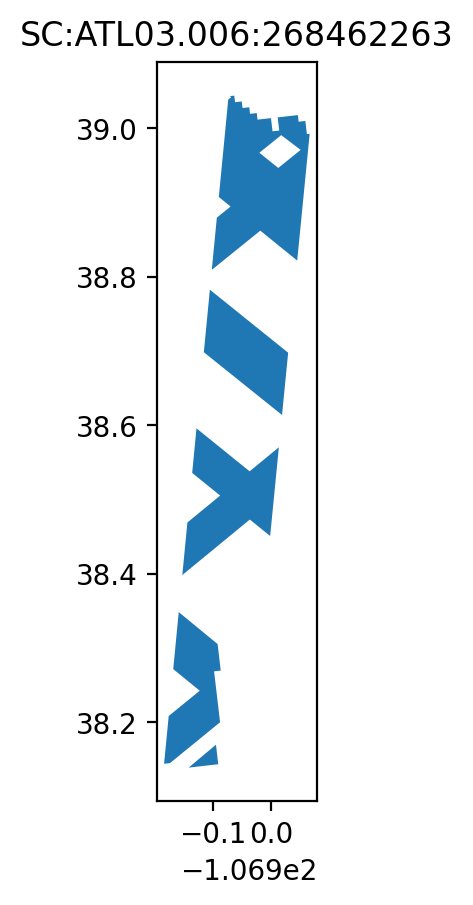

In [4]:
# Hone in on single granule as a pandas series
i = 0
granule_gdf = gf_is2.iloc[[i]]
granule = gf_is2.iloc[i]
granule_gdf.plot()  # needs to be a geodataframe
plt.title(granule.id);
# The icesat-2 track trends N-S, and is crossed by multiple GEDI tracks, resulting in the crosshatched appearance

In [12]:
data_is2 = coincident.io.sliderule.subset_atl06(
    granule_gdf,
    include_worldcover=True,
)

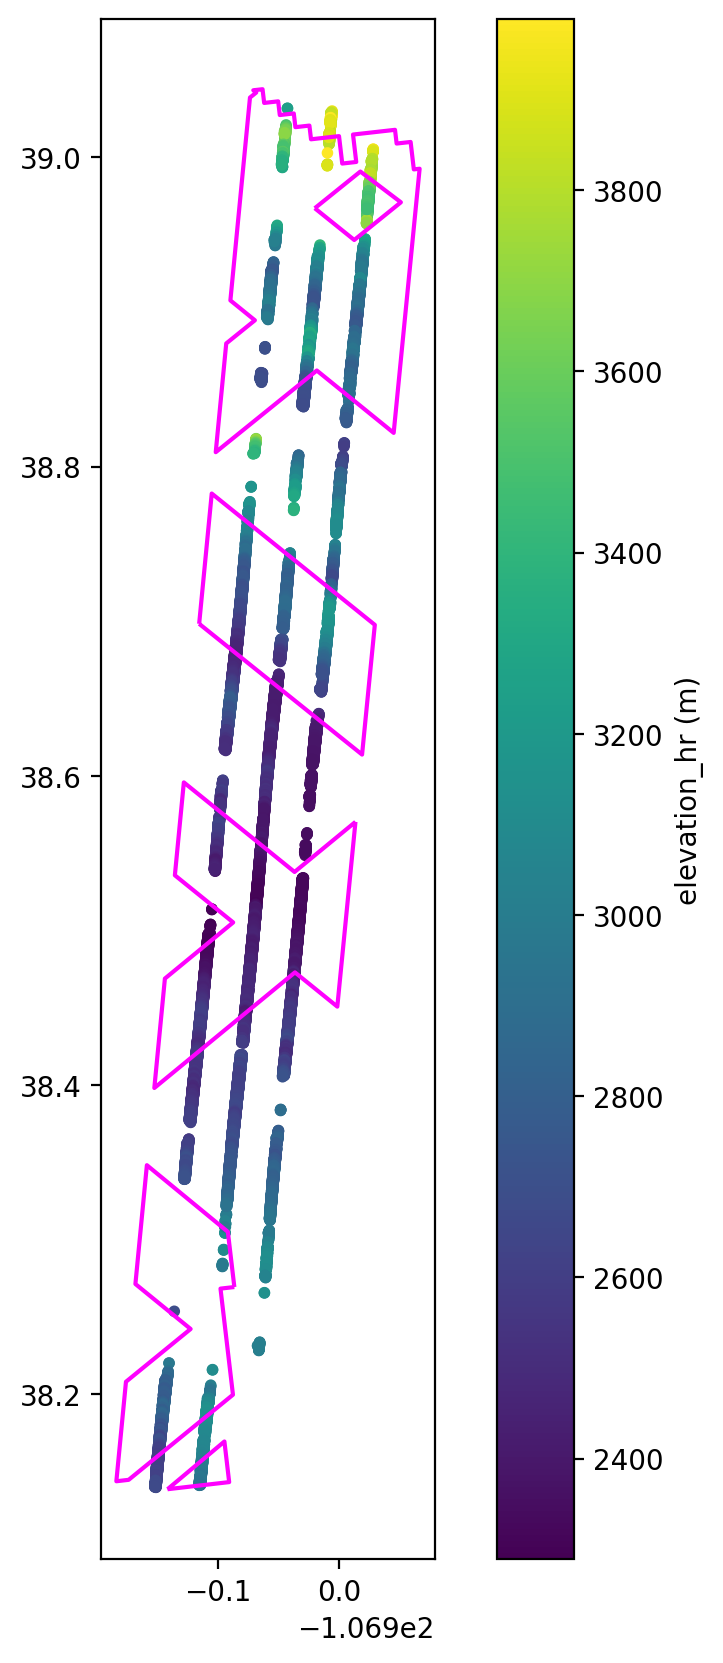

In [13]:
# Plot this data and overlay footprint
fig, ax = plt.subplots(figsize=(8, 10))
plt.scatter(
    x=data_is2.geometry.x,
    y=data_is2.geometry.y,
    c=data_is2.h_li,
    s=10,
)
granule_gdf.dissolve().boundary.plot(ax=ax, color="magenta")
cb = plt.colorbar()
cb.set_label("elevation_hr (m)")

```{note}
`sliderule` gets data from the envelope of multipolygon, not only data within intersecting GEDI tracks. Along-track gaps are where there is missing data.
```

In [14]:
# Here, we specify aoi=granule_gdf to only return GEDI data
# in our icesat-2 track of interest
data_gedi = coincident.io.sliderule.subset_gedi02a(
    gf_gedi,
    aoi=granule_gdf,
    include_worldcover=True,
)

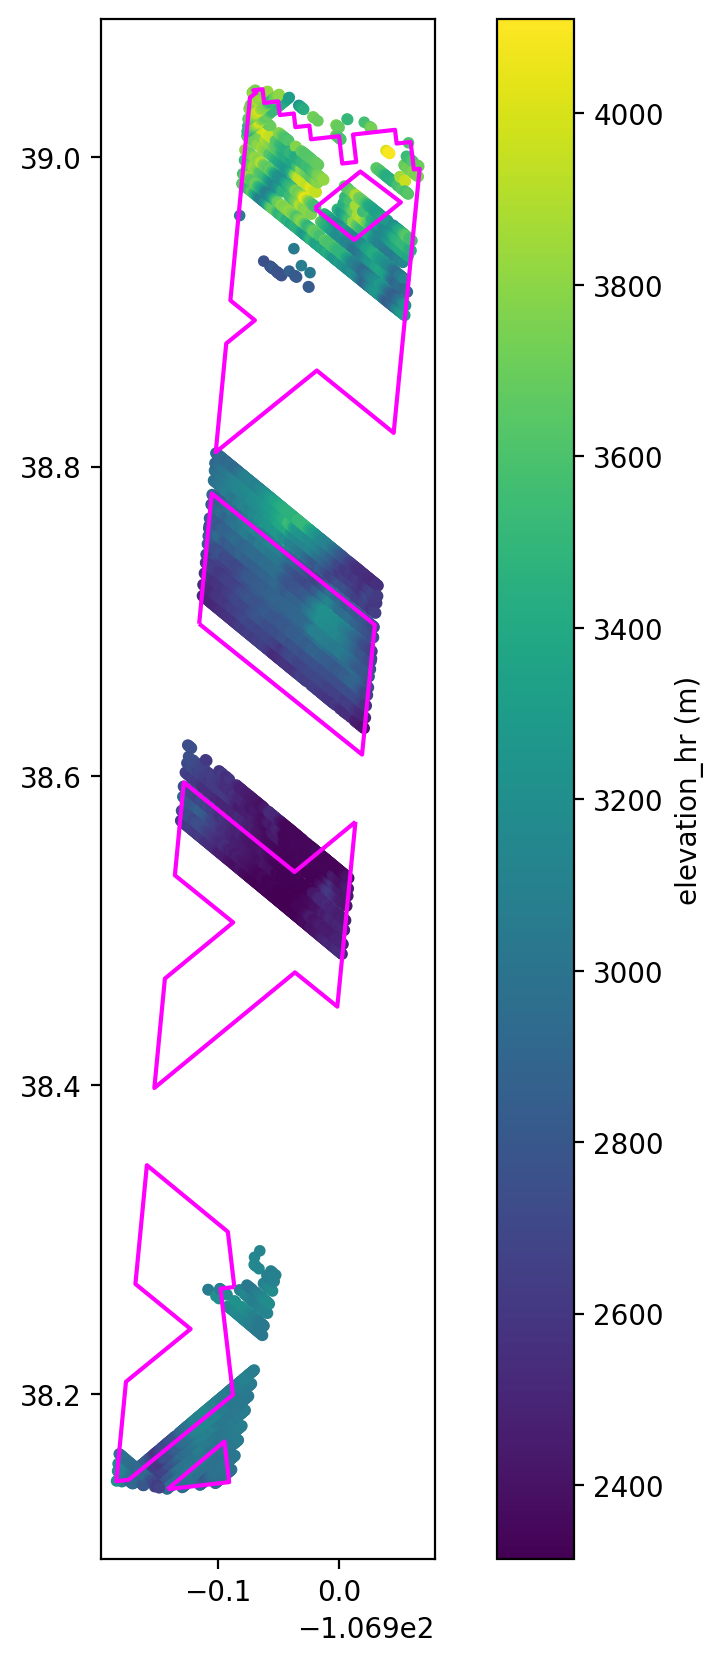

In [15]:
# Plot this data and overlay footprint
fig, ax = plt.subplots(figsize=(8, 10))
plt.scatter(
    x=data_gedi.geometry.x,
    y=data_gedi.geometry.y,
    c=data_gedi.elevation_hr,
    s=10,
)
granule_gdf.dissolve().boundary.plot(ax=ax, color="magenta")
cb = plt.colorbar()
cb.set_label("elevation_hr (m)")

**NOTE** Like ICESat-2, it's possible to have points falling outside the estimated footprints

## Spatial join: nearest points

NOTE: we will not worry about the difference in time of acquisition between adjacent points for now

In [ ]:
utm_crs = granule_gdf.estimate_utm_crs()
data_is2_utm = data_is2.to_crs(utm_crs)
data_gedi_utm = data_gedi.to_crs(utm_crs)

CPU times: user 56.2 ms, sys: 3.68 ms, total: 59.9 ms
Wall time: 60.1 ms


In [59]:
# find nearest IS2 point to each GEDI
close_gedi = data_gedi_utm.sjoin_nearest(
    data_is2_utm,
    how="left",
    max_distance=100,  # at most 100m apart
    distance_col="distances",
)
# index is GEDI subset (with _left added), with _right apprended to is2 columns + Distances in meters
close_gedi = close_gedi[close_gedi["distances"].notna()]

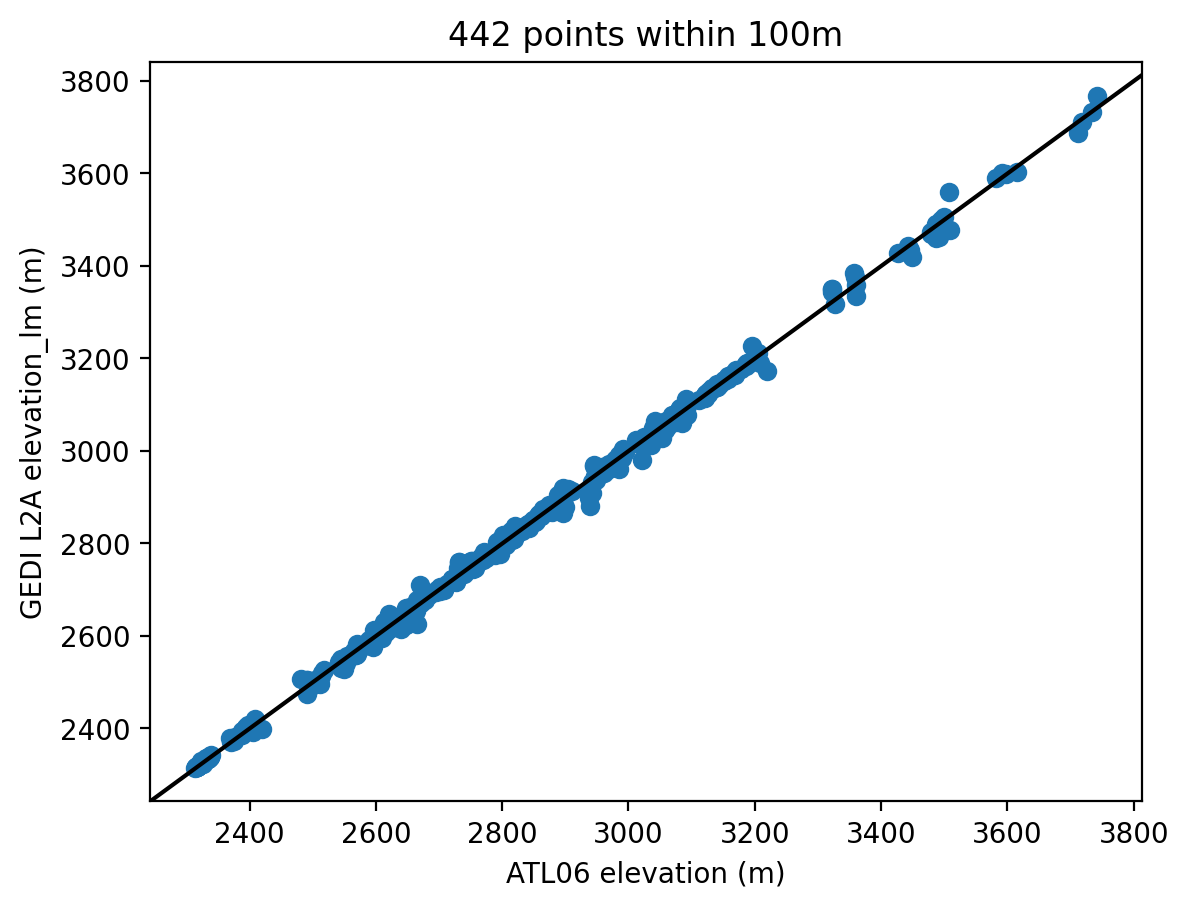

In [60]:
fig, ax = plt.subplots()
plt.scatter(close_gedi.h_li, close_gedi.elevation_lm)
ax.axline((0, 0), slope=1, color="k", transform=ax.transAxes)
plt.xlabel("ATL06 elevation (m)")
plt.ylabel("GEDI L2A elevation_lm (m)")
plt.title(f"{len(close_gedi)} points within 100m");

## Sample 3DEP

Sample 3DEP 1m DEM at the subset of GEDI Points

```{note}
SlideRule returns all elevation data in EPSG:7912
```

In [ ]:
# Restrict to only DEMs derived from specific WESM LiDAR project
close_gedi_3dep = coincident.io.sliderule.sample_3dep(
    close_gedi,
    project_name=gf_lidar["project"].iloc[0],
)

In [64]:
# Add 3DEP elevation values to existing dataframe
close_gedi["elevation_3dep"] = close_gedi_3dep.value.values

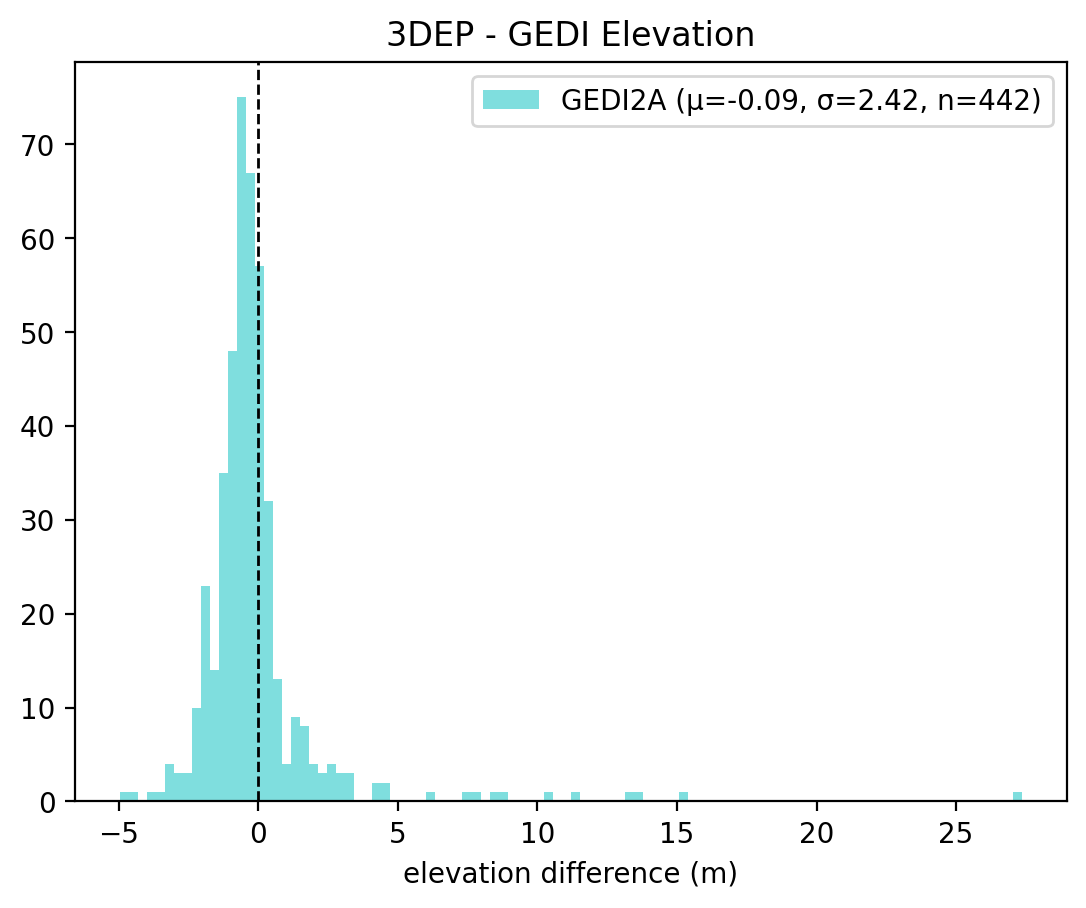

In [73]:
diff_3dep = close_gedi.elevation_3dep - close_gedi.elevation_lm.values

label = f"GEDI2A (μ={np.nanmean(diff_3dep):.2f}, σ={np.nanstd(diff_3dep):.2f}, n={len(diff_3dep)})"
plt.axvline(0, color="k", linestyle="dashed", linewidth=1)
plt.hist(diff_3dep, bins=100, color="c", alpha=0.5, label=label)
plt.xlabel("elevation difference (m)")
plt.title("3DEP - GEDI Elevation")
plt.legend();

In [66]:
# Geometries of nearest IS2 points
close_is2 = data_is2_utm.loc[close_gedi.time_right]

In [67]:
# Sample 3DEP at the subset of GEDI Points
close_is2_3dep = coincident.io.sliderule.sample_3dep(
    close_is2,
    project_name=gf_lidar["project"].iloc[0],
)

In [68]:
close_is2["elevation_3dep"] = close_is2_3dep.value.values

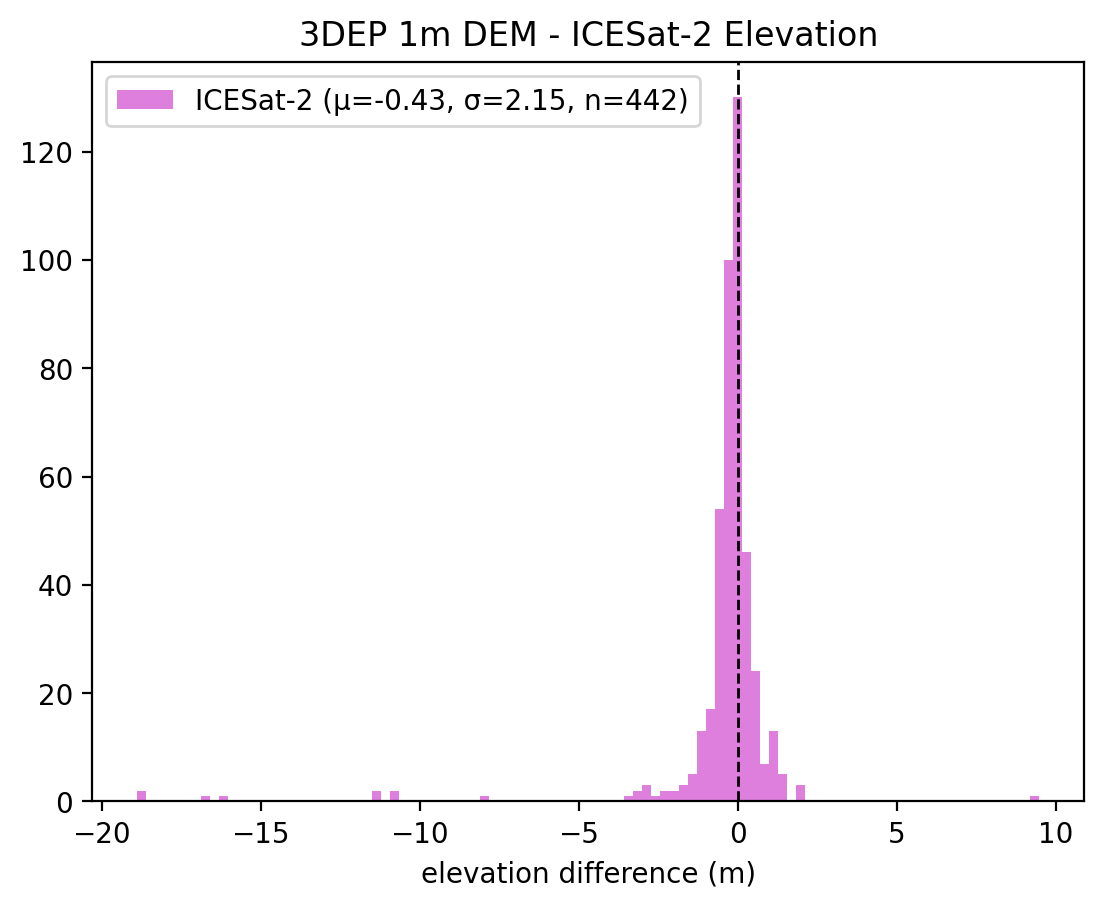

In [72]:
diff_3dep = close_is2.elevation_3dep - close_is2.h_li.values

label = f"ICESat-2 (μ={np.nanmean(diff_3dep):.2f}, σ={np.nanstd(diff_3dep):.2f}, n={len(diff_3dep)})"
plt.axvline(
    0,
    color="k",
    linestyle="dashed",
    linewidth=1,
)
plt.hist(diff_3dep, bins=100, color="m", alpha=0.5, label=label)
plt.xlabel("elevation difference (m)")
plt.title("3DEP 1m DEM - ICESat-2 Elevation")
plt.legend();

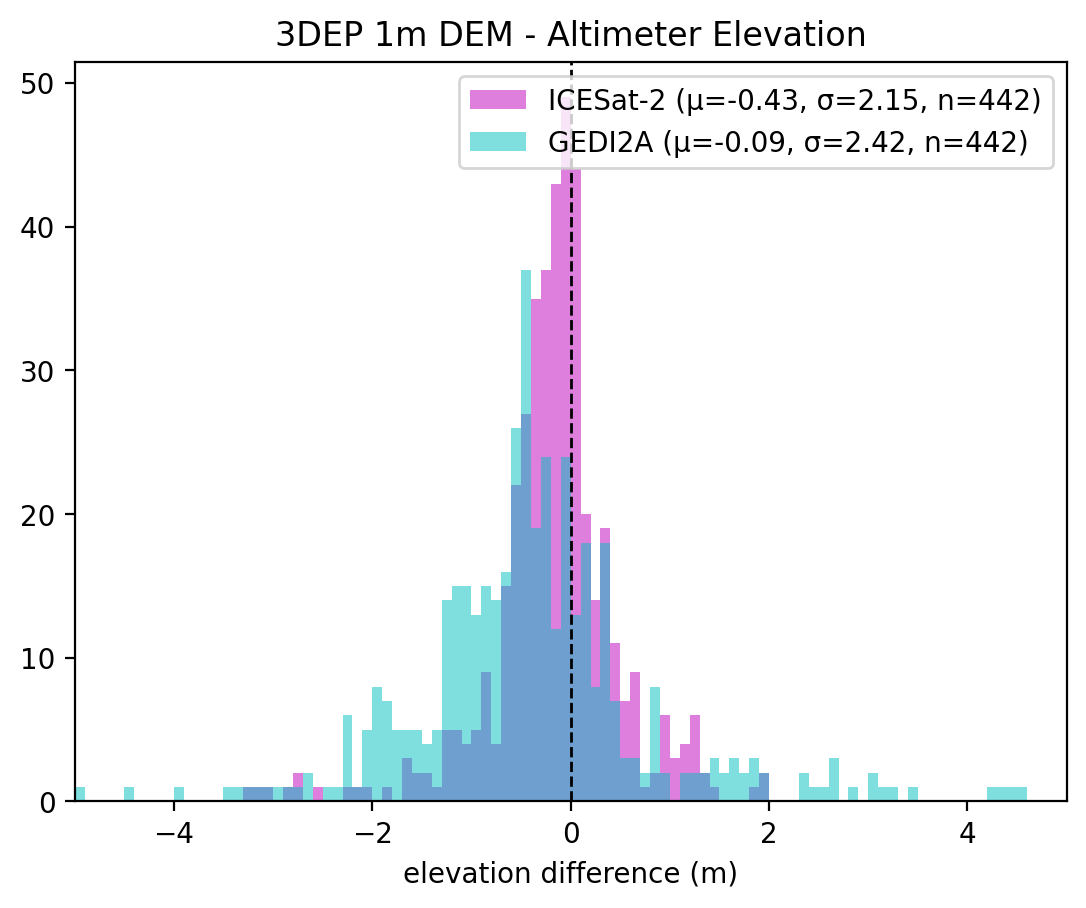

In [80]:
plt.axvline(0, color="k", linestyle="dashed", linewidth=1)

diff_3dep = close_is2.elevation_3dep - close_is2.h_li.values
label = f"ICESat-2 (μ={np.nanmean(diff_3dep):.2f}, σ={np.nanstd(diff_3dep):.2f}, n={len(diff_3dep)})"
plt.hist(diff_3dep, range=[-5, 5], bins=100, color="m", alpha=0.5, label=label)

diff_3dep = close_gedi.elevation_3dep - close_gedi.elevation_lm.values
label = f"GEDI2A (μ={np.nanmean(diff_3dep):.2f}, σ={np.nanstd(diff_3dep):.2f}, n={len(diff_3dep)})"
plt.hist(diff_3dep, range=[-5, 5], bins=100, color="c", alpha=0.5, label=label)

plt.xlabel("elevation difference (m)")
plt.title("3DEP 1m DEM - Altimeter Elevation")
plt.xlim(-5, 5)
plt.legend();